# Overview
- RNN を試してみる
- ref
    - https://qiita.com/yukiB/items/5d5b202af86e3c587843
    - https://qiita.com/takilog/items/47b22cbd0bd08cb7ec70

# Const

# Import everything I need :)

In [1]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastprogress import progress_bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable

# Preparation

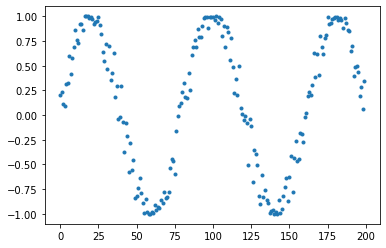

In [2]:
random.seed(0)
# 乱数の係数
random_factor = 0.3
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: np.sin(x * (2 * np.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
plt.plot(df['sin_t'].values[:200], '.')

In [15]:
df['sin_t'].iloc[0:10].values.shape

(10,)

In [20]:
def _load_data(df, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(df)-n_prev):
        docX.append(df.iloc[i:i+n_prev])
        docY.append(df.iloc[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split_seq(df, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)

length_of_sequences = 100
(X_train, y_train), (X_test, y_test) = train_test_split_seq(df["sin_t"], n_prev =length_of_sequences)  

In [21]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)

In [22]:
train = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train, batch_size=100, shuffle=True)

# Run

model

In [23]:
class Predictor(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Predictor, self).__init__()
        self.rnn = nn.RNN(n_input, n_hidden, num_layers=1, batch_first=True)
        self.out = nn.Linear(n_hidden, n_output)

    def forward(self, x, h=None):
        output, hp = self.rnn(x.unsqueeze(1), h)
        output = self.out(output.squeeze(1))
        return output, hp

In [24]:
fixed_length = 100

model = Predictor(fixed_length, 64, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [29]:
n_epoch = 100
lloss = []
preds = []
for epoch in progress_bar(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        bX, by = data
        bX, by = Variable(bX), Variable(by)
        optimizer.zero_grad()
        output, _ = model(bX)
        loss = criterion(output, by)
        loss.backward()
        preds.append(output)
        optimizer.step()
        
        running_loss += loss.data
        
    lloss.append(running_loss)

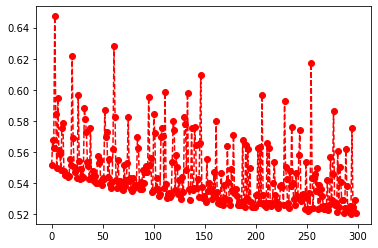

In [28]:
plt.plot(lloss[1:], "ro--")